## Image Classification
In this project, we'll classify images from the CIFAR-10 dataset. The dataset consists of airplanes, dogs, cats, and other objects. we'll preprocess the images, then train a convolutional neural network on all the samples. The images need to be normalized and the labels need to be one-hot encoded. we'll build a convolutional, max pooling, dropout, and fully connected layers. At the end, we'll get to see the neural network's predictions on the sample images.


## import the libraries we have to use

In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
import tensorflow as tf
warnings.filterwarnings("ignore")

## load data

In [2]:
def load_cfar10_batch(cifar_10_batches_py, batch_id):
    with open(cifar_10_batches_py + '/data_batch_' + str(batch_id), mode='rb') as file:
        batch = pickle.load(file, encoding='latin1')
    
    # features and labels
    features = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
    labels = batch['labels']

    return features, labels

In [3]:

# load all training data
cifar10_path = 'cifar_10_batches_py'
# five batches training data
x_train, y_train = load_cfar10_batch(cifar10_path, 1)
for i in range(2, 6):
    features, labels = load_cfar10_batch(cifar10_path, i)
    x_train, y_train = np.concatenate([x_train, features]), np.concatenate([y_train, labels])

In [4]:

# load all test data
with open(cifar10_path + '/test_batch', mode='rb') as file:
    batch = pickle.load(file, encoding='latin1')
    x_test = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
    y_test = batch['labels']

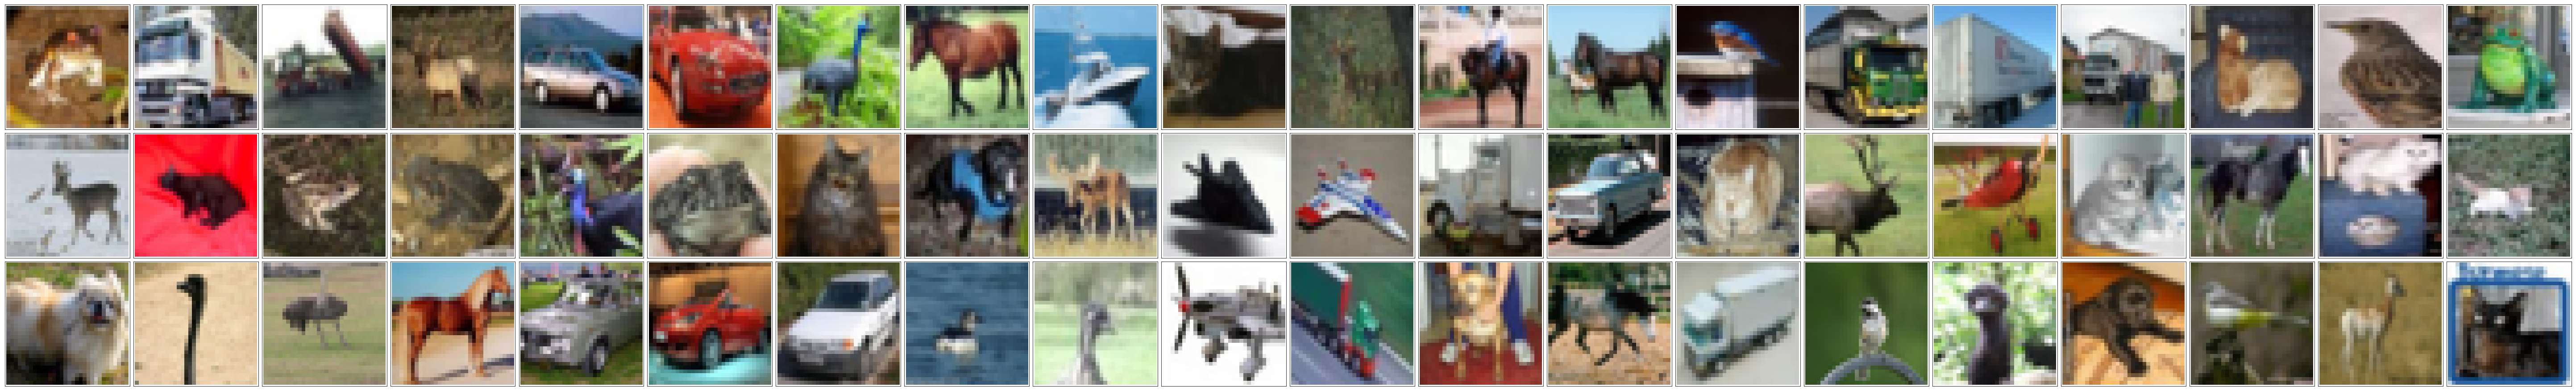

In [5]:

# show the pics
fig, axes = plt.subplots(nrows=3, ncols=20, sharex=True, sharey=True, figsize=(80,12))
imgs = x_train[:60]

for image, row in zip([imgs[:20], imgs[20:40], imgs[40:60]], axes):
    for img, ax in zip(image, row):
        ax.imshow(img)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

fig.tight_layout(pad=0.1)

In [6]:

# reshape the data
x_train_rows = x_train.reshape(x_train.shape[0], 32 * 32 * 3)
x_test_rows = x_test.reshape(x_test.shape[0], 32 * 32 * 3)

# scale the pixel
from sklearn.preprocessing import MinMaxScaler
minmax = MinMaxScaler()

x_train_rows = minmax.fit_transform(x_train_rows)
x_test_rows = minmax.fit_transform(x_test_rows)


# build the model
## first,i apply knn(the traditional way) to classify the images,lets see how performance it can get

In [12]:

# we use knn from the library in sklearn
from sklearn.neighbors import KNeighborsClassifier

# we choose which k value is the best through the iteration
k = [1,5]
for i in k:
    model = KNeighborsClassifier(n_neighbors=i, algorithm='ball_tree', n_jobs=6)
    model.fit(x_train_rows, y_train)
    preds = model.predict(x_test_rows)
    print('k = %s, Accuracy = %f' % (i, np.mean(y_test==preds)))

k = 1, Accuracy = 0.353900
k = 5, Accuracy = 0.339800


we can see that, it is a lot more accurate than our randomly guess. When we randomly guess the image category, the accuracy rate is about 10%, KNN classification can improve the accuracy to about 28%. Of course, interested partners can also test other K values, while in the above algorithm, the default distance is measured by the European distance, you can also try other metrics to model. Although KNN has improved on the test dataset, this accuracy is still too low. In addition, KNN has a disadvantage in that all calculation time is in the predict phase. When a new image comes, it involves a lot of distance calculation, which means that once we want to use it for image recognition, That may have to wait for a long time to get the result, but not so accurate.

In [7]:

from sklearn.preprocessing import MinMaxScaler
minmax = MinMaxScaler()

# reshape the data
x_train_rows = x_train.reshape(x_train.shape[0], 32 * 32 * 3)
x_test_rows = x_test.reshape(x_test.shape[0], 32 * 32 * 3)

# normalization
x_train = minmax.fit_transform(x_train_rows)
x_test = minmax.fit_transform(x_test_rows)
# reshape to 32 x 32 x 3
x_train = x_train.reshape(x_train.shape[0], 32, 32, 3)
x_test = x_test.reshape(x_test.shape[0], 32, 32, 3)

In [8]:
#one-hot encoding for labels
from sklearn.preprocessing import LabelBinarizer
n_class = 10 #总共10类
lb = LabelBinarizer().fit(np.array(range(n_class)))

y_train = lb.transform(y_train)
y_test = lb.transform(y_test)

In [9]:
#divide data into train and test
from sklearn.model_selection import train_test_split

train_ratio = 0.8
x_train_, x_val, y_train_, y_val = train_test_split(x_train, 
                                                    y_train, 
                                                    train_size=train_ratio,
                                                    random_state=123)

## build the network
parameters settings

In [16]:
img_shape = x_train_.shape
keep_prob = 0.6
epochs=5
batch_size=64

input and label variable

In [17]:
inputs_ = tf.placeholder(tf.float32, [None, 32, 32, 3], name='inputs_')
targets_ = tf.placeholder(tf.float32, [None, n_class], name='targets_')

build the cnn network

In [18]:
# conv+pooling
# 32 x 32 x 3 to 32 x 32 x 64
conv1 = tf.layers.conv2d(inputs_, 64, (2,2), padding='same', activation=tf.nn.relu, 
                         kernel_initializer=tf.truncated_normal_initializer(mean=0.0, stddev=0.1))
# 32 x 32 x 64 to 16 x 16 x 64
conv1 = tf.layers.max_pooling2d(conv1, (2,2), (2,2), padding='same')

# conv+pooling
# 16 x 16 x 64 to 16 x 16 x 128
conv2 = tf.layers.conv2d(conv1, 128, (4,4), padding='same', activation=tf.nn.relu,
                         kernel_initializer=tf.truncated_normal_initializer(mean=0.0, stddev=0.1))
# 16 x 16 x 128 to 8 x 8 x 128
conv2 = tf.layers.max_pooling2d(conv2, (2,2), (2,2), padding='same')

# reshape output
shape = np.prod(conv2.get_shape().as_list()[1:])
conv2 = tf.reshape(conv2,[-1, shape])

# first fully conv
# 8 x 8 x 128 to 1 x 1024
fc1 = tf.contrib.layers.fully_connected(conv2, 1024, activation_fn=tf.nn.relu)
fc1 = tf.nn.dropout(fc1, keep_prob)

# second fully conv
# 1 x 1024 to 1 x 512
fc2 = tf.contrib.layers.fully_connected(fc1, 512, activation_fn=tf.nn.relu)

# logits layer
# 1 x 512 to 1 x 10
logits_ = tf.contrib.layers.fully_connected(fc2, 10, activation_fn=None)
logits_ = tf.identity(logits_, name='logits_')

# cost & optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits_, labels=targets_))
optimizer = tf.train.AdamOptimizer(0.001).minimize(cost)

# accuracy
correct_pred = tf.equal(tf.argmax(logits_, 1), tf.argmax(targets_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

train the model

In [ ]:

save_model_path='./test_cifar'
count = 0
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    for epoch in range(epochs):
        for batch_i in range(img_shape[0]//batch_size-1):
            feature_batch = x_train_[batch_i * batch_size: (batch_i+1)*batch_size]
            label_batch = y_train_[batch_i * batch_size: (batch_i+1)*batch_size]
            train_loss, _ = sess.run([cost, optimizer],
                                     feed_dict={inputs_: feature_batch,
                                                targets_: label_batch})

            val_acc = sess.run(accuracy,
                               feed_dict={inputs_: x_val,
                                          targets_: y_val})
            
            if(count%10==0):
                print('Epoch {:>2}, Train Loss {:.4f}, Validation Accuracy {:4f} '.format(epoch + 1, train_loss, val_acc))
            
            count += 1
    
    # 存储参数
    saver = tf.train.Saver()
    save_path = saver.save(sess, save_model_path)

In [13]:
import random

In [14]:
save_model_path='./test_cifar'
loaded_graph = tf.Graph()
test_batch_size= 100
with tf.Session(graph=loaded_graph) as sess:
    # 加载模型
    loader = tf.train.import_meta_graph(save_model_path + '.meta')
    loader.restore(sess, save_model_path)

    # 加载tensor
    loaded_x = loaded_graph.get_tensor_by_name('inputs_:0')
    loaded_y = loaded_graph.get_tensor_by_name('targets_:0')
    loaded_logits = loaded_graph.get_tensor_by_name('logits_:0')
    loaded_acc = loaded_graph.get_tensor_by_name('accuracy:0')

    # 计算test的准确率
    test_batch_acc_total = 0
    test_batch_count = 0
    
    print("Begin test...")
    for batch_i in range(x_test.shape[0]//test_batch_size-1):
        test_feature_batch = x_test[batch_i * test_batch_size: (batch_i+1)*test_batch_size]
        test_label_batch = y_test[batch_i * test_batch_size: (batch_i+1)*test_batch_size]
        test_batch_acc_total += sess.run(
            loaded_acc,
            feed_dict={loaded_x: test_feature_batch, loaded_y: test_label_batch})
        test_batch_count += 1

    print('Test Accuracy: {}\n'.format(test_batch_acc_total/test_batch_count))

INFO:tensorflow:Restoring parameters from ./test_cifar
Begin test...
Test Accuracy: 0.6753535367021657



# result analysis
### the final test accuracy is 67%,it's much more higher than traditional method(KNN),but in the area of deep learning,its not very high,there are the reasons below:
<br>
<br>
<li>i run this program on my pc ,it took me two days and nights to get the results. the ability of computing of pc is limited.</li>
<li>i just made the two conv layer and two pooling layer,it is a little bit shallow according to this sixty thousand pics。</li>

## with enough GPUs,we can add more layers or do some fine-tunings,then we can get the better results.
